In [1]:
from os import listdir
import cv2
from typing import List
import random
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from torchvision import models, transforms, datasets

In [4]:
# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### CONFIG

In [5]:
# Hyperparameters.
learning_rate = 1e-3
batch_size = 128
num_epochs = 50
train_split = 0.7
image_size = (224, 224)
num_workers = 2


In [24]:
# Load data.
dataset_WLASL = "WLASL"
dataset_animals = "animals"

dataset = dataset_animals
data_dir = f"../../data/{dataset}/frames_100"


### Input labels with images

In [7]:
input_labels = listdir(data_dir)
input_labels[:5]

['butterfly', 'cat', 'chicken', 'cow', 'dog']

In [8]:
def show_image(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()
  
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

chicken


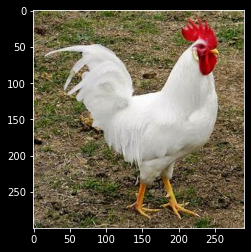

In [9]:
label = input_labels[random.randint(0, len(input_labels) - 1)]
label_images = listdir(data_dir + "/" + label)
label_images

print(label)

image = cv2.imread(data_dir + "/" + label + "/" + label_images[0])
show_image(image)


### Create dataloader for pytorch

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler


### Using random_split

In [11]:
def load_split_dataset(data_dir, train_split=0.7, batch_size=32, image_size=224):
    transform = transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size-10),
            transforms.ToTensor(),
        ]
    )
    dataset = datasets.ImageFolder(data_dir, transform=transform)

    classes = dataset.classes
    dataset_len = len(dataset)

    train_split = int(train_split * dataset_len)
    tets_split = dataset_len - train_split
    train_set, test_set = random_split(dataset, [train_split, tets_split])

    train_loader = DataLoader(
        dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    test_loader = DataLoader(
        dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    return train_loader, test_loader, classes


### Solution to unbalanced labels 1: Random dataset split to solve unbalanced labels

In [12]:
def load_split_dataset(data_dir, train_split=0.7, batch_size=32, image_size=224):
    transform = transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ]
    )
    dataset = datasets.ImageFolder(data_dir, transform=transform)

    classes = dataset.classes
    dataset_len = len(dataset)

    ran_ind = torch.randperm(dataset_len)  # 1. random
    # seq_ind = list(range(dataset_len))  # 2. sequential

    indices = ran_ind
    split = int(np.floor(train_split * dataset_len))
    train_indices, test_indices = indices[:split], indices[split:]

    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(
        dataset,
        sampler=train_sampler,
        batch_size=batch_size,
        num_workers=num_workers,
    )
    test_loader = DataLoader(
        dataset,
        sampler=test_sampler,
        batch_size=batch_size,
        num_workers=num_workers,
    )

    return train_loader, test_loader, classes


### Uso del dataset

In [13]:
train_loader, test_loader, classes = load_split_dataset(
    data_dir,
    train_split=train_split,
    batch_size=batch_size,
    image_size=image_size,
)

num_classes = len(classes)

print(len(train_loader))
print(len(test_loader))
print(train_loader.batch_size)

6
3
128


### Check how many images are in each loader for every label

In [14]:
def check_balance_status(loader):
    class_count = {}

    for _, targets in loader:
        for target in targets:
            label = classes[target]
            if label not in class_count:
                class_count[label] = 0
            class_count[label] += 1

    return sorted(class_count.items())


train_class_count = check_balance_status(train_loader)
test_class_count = check_balance_status(test_loader)

pc_mean = 0

for tr, te in zip(train_class_count, test_class_count):
    tr_pc = tr[1] / (tr[1] + te[1]) * 100
    pc_mean += tr_pc
    print(f"{tr[0]} - TR: {tr[1]} TS: {te[1]} - PC-TR: {tr_pc:.2f}%")
    
pc_mean /= len(train_class_count)
print(f"Mean PC-TR: {pc_mean:.2f}%")


butterfly - TR: 54 TS: 30 - PC-TR: 64.29%
cat - TR: 100 TS: 32 - PC-TR: 75.76%
chicken - TR: 46 TS: 26 - PC-TR: 63.89%
cow - TR: 79 TS: 29 - PC-TR: 73.15%
dog - TR: 63 TS: 21 - PC-TR: 75.00%
elephant - TR: 82 TS: 26 - PC-TR: 75.93%
horse - TR: 81 TS: 39 - PC-TR: 67.50%
sheep - TR: 57 TS: 27 - PC-TR: 67.86%
spider - TR: 56 TS: 28 - PC-TR: 66.67%
squirrel - TR: 70 TS: 38 - PC-TR: 64.81%
Mean PC-TR: 69.48%


### Load pretrained resnet model

In [15]:
# Load pretrain model & modify it.
model = models.resnet50(pretrained=True)

In [16]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes),
    nn.LogSoftmax(dim=1),
)


In [17]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Freeze model and train only last layer

In [18]:
def train():
    # Train network.
    costs = []

    for epoch in range(num_epochs):
        losses = []

        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible.
            data = data.to(device)
            targets = targets.to(device)

            # forward.
            scores = model(data)
            loss = criterion(scores, targets)
            losses.append(loss.item())

            # backward.
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step.
            optimizer.step()

        cost = sum(losses) / len(losses)
        costs.append(cost)
        print(f"Cost at epoch {epoch + 1} is {cost:.5f}")

    return costs


costs = train()


Cost at epoch 1 is 1.53130
Cost at epoch 2 is 0.45838
Cost at epoch 3 is 0.21317
Cost at epoch 4 is 0.11541
Cost at epoch 5 is 0.07392
Cost at epoch 6 is 0.06802
Cost at epoch 7 is 0.04796
Cost at epoch 8 is 0.03426
Cost at epoch 9 is 0.02885
Cost at epoch 10 is 0.03472
Cost at epoch 11 is 0.01950
Cost at epoch 12 is 0.02827
Cost at epoch 13 is 0.01830
Cost at epoch 14 is 0.01906
Cost at epoch 15 is 0.01463
Cost at epoch 16 is 0.01794
Cost at epoch 17 is 0.01341
Cost at epoch 18 is 0.01193
Cost at epoch 19 is 0.01034
Cost at epoch 20 is 0.00896
Cost at epoch 21 is 0.00842
Cost at epoch 22 is 0.00606
Cost at epoch 23 is 0.01089
Cost at epoch 24 is 0.01120
Cost at epoch 25 is 0.00639
Cost at epoch 26 is 0.00546
Cost at epoch 27 is 0.00539
Cost at epoch 28 is 0.00396
Cost at epoch 29 is 0.00566
Cost at epoch 30 is 0.00596
Cost at epoch 31 is 0.00460
Cost at epoch 32 is 0.00348
Cost at epoch 33 is 0.00378
Cost at epoch 34 is 0.00371
Cost at epoch 35 is 0.00375
Cost at epoch 36 is 0.00402
C

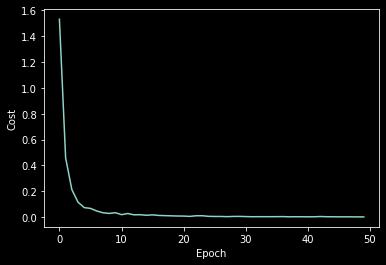

In [19]:
def plot_costs(costs):
    # Plot cost.
    plt.plot(costs)
    plt.ylabel("Cost")
    plt.xlabel("Epoch")
    plt.show()


plot_costs(costs)


### Save model

In [25]:
model_path = f"../../models/resnet_{dataset}.pth"

In [26]:
# Export model.
torch.save(model, model_path)


### Load saved model

In [27]:
# Import model for acc test.
model = torch.load(model_path)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Test net

In [28]:
# Check accuracy on training & test to see how good our model predicts.
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

            # Output both images to compare.
            print(f"Images for {i+1}")
            imshow(make_grid(x.cpu()))

            print(f"Predictions for batch {i+1} ")
            print([classes[int(i)] for i in predictions])

            print(f"Ground truth for batch {i+1}")
            print([classes[int(i)] for i in y])
            
            print("---------------------------------\n\n")
            break

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )


Checking accuracy on Training Set
Images for 1


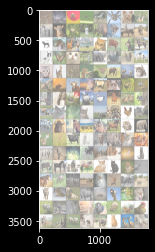

Predictions for batch 1 
['squirrel', 'elephant', 'spider', 'squirrel', 'horse', 'spider', 'dog', 'squirrel', 'horse', 'sheep', 'butterfly', 'dog', 'spider', 'spider', 'horse', 'elephant', 'horse', 'squirrel', 'horse', 'cow', 'cat', 'cow', 'dog', 'horse', 'cat', 'butterfly', 'cat', 'sheep', 'elephant', 'chicken', 'chicken', 'cow', 'cat', 'cat', 'squirrel', 'squirrel', 'spider', 'elephant', 'sheep', 'cat', 'cow', 'elephant', 'cow', 'butterfly', 'horse', 'cat', 'spider', 'spider', 'squirrel', 'elephant', 'butterfly', 'horse', 'chicken', 'chicken', 'chicken', 'squirrel', 'elephant', 'cat', 'spider', 'cat', 'cow', 'spider', 'chicken', 'cow', 'chicken', 'cow', 'horse', 'elephant', 'cat', 'horse', 'cat', 'elephant', 'chicken', 'butterfly', 'cow', 'dog', 'elephant', 'elephant', 'cat', 'squirrel', 'elephant', 'elephant', 'spider', 'dog', 'elephant', 'squirrel', 'butterfly', 'cat', 'elephant', 'horse', 'cat', 'horse', 'cat', 'cat', 'cat', 'sheep', 'horse', 'horse', 'sheep', 'elephant', 'spider'

In [29]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)


Checking accuracy on Test Set
Images for 1


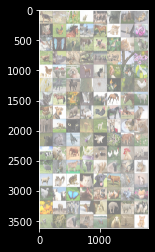

Predictions for batch 1 
['dog', 'butterfly', 'butterfly', 'sheep', 'cow', 'squirrel', 'sheep', 'squirrel', 'cat', 'chicken', 'horse', 'horse', 'horse', 'cat', 'spider', 'butterfly', 'squirrel', 'butterfly', 'elephant', 'cow', 'dog', 'butterfly', 'cat', 'dog', 'chicken', 'cat', 'spider', 'squirrel', 'horse', 'elephant', 'squirrel', 'butterfly', 'chicken', 'elephant', 'dog', 'horse', 'dog', 'squirrel', 'butterfly', 'spider', 'spider', 'horse', 'horse', 'squirrel', 'spider', 'butterfly', 'spider', 'chicken', 'cat', 'horse', 'butterfly', 'cat', 'dog', 'horse', 'horse', 'sheep', 'cow', 'dog', 'elephant', 'cat', 'chicken', 'horse', 'horse', 'sheep', 'elephant', 'cow', 'cat', 'squirrel', 'sheep', 'dog', 'cat', 'cat', 'cow', 'cat', 'horse', 'butterfly', 'cat', 'squirrel', 'horse', 'chicken', 'cow', 'sheep', 'elephant', 'spider', 'sheep', 'chicken', 'chicken', 'dog', 'chicken', 'squirrel', 'cow', 'elephant', 'cat', 'elephant', 'elephant', 'cat', 'sheep', 'squirrel', 'squirrel', 'cat', 'dog', '

In [30]:
print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)

### Check train and test on same class.

In [31]:
def predict_class(loader, model, debug_label):

    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)

        scores = model(images)
        _, predictions = scores.max(1)

        for i, (image, target) in enumerate(zip(images, targets)):
            label = classes[target]
            if label != debug_label:
                continue

            # Predict label for image.
            prediction_id = predictions[i]
            prediction = classes[prediction_id]

            # Show image.
            imshow(image.cpu())

            print(f"Prediction: {prediction}. Ground truth: {label}")

            return

    return sorted(class_count.items())


In [32]:
debug_label = "time"


In [33]:
print(f"Prediction for {debug_label} and train set")
predict_class(train_loader, model, debug_label)


Prediction for time and train set


NameError: name 'class_count' is not defined

Prediction for time and test set


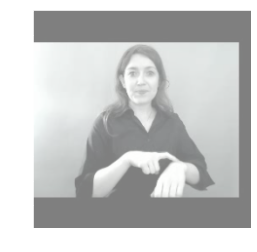

Prediction: time. Ground truth: time


In [ ]:
print(f"Prediction for {debug_label} and test set")
predict_class(test_loader, model, debug_label)
